In [1]:
import pandas as pd
import subprocess
import numpy as np
from tqdm import tqdm

In [2]:
data = pd.read_parquet('human_eval.parquet')
data

,task_id,prompt,canonical_solution,test,entry_point
0,HumanEval/0,from typing import List\n\n\ndef has_close_ele...,"for idx, elem in enumerate(numbers):\n ...","\n\nMETADATA = {\n 'author': 'jt',\n 'da...",has_close_elements
1,HumanEval/1,from typing import List\n\n\ndef separate_pare...,result = []\n current_string = []\n ...,"\n\nMETADATA = {\n 'author': 'jt',\n 'da...",separate_paren_groups
2,HumanEval/2,\n\ndef truncate_number(number: float) -> floa...,return number % 1.0\n,"\n\nMETADATA = {\n 'author': 'jt',\n 'da...",truncate_number
3,HumanEval/3,from typing import List\n\n\ndef below_zero(op...,balance = 0\n\n for op in operations:\n...,"\n\nMETADATA = {\n 'author': 'jt',\n 'da...",below_zero
4,HumanEval/4,from typing import List\n\n\ndef mean_absolute...,mean = sum(numbers) / len(numbers)\n re...,"\n\nMETADATA = {\n 'author': 'jt',\n 'da...",mean_absolute_deviation
...,...,...,...,...,...
159,HumanEval/159,"\ndef eat(number, need, remaining):\n """"""\n...",if(need <= remaining):\n return [ n...,def check(candidate):\n\n # Check some simp...,eat
160,HumanEval/160,"\ndef do_algebra(operator, operand):\n """"""\...",expression = str(operand[0])\n for oprt...,def check(candidate):\n\n # Check some simp...,do_algebra
161,HumanEval/161,"\ndef solve(s):\n """"""You are given a string...",flg = 0\n idx = 0\n new_str = list(s...,def check(candidate):\n\n # Check some simp...,solve
162,HumanEval/162,"\ndef string_to_md5(text):\n """"""\n Given...",import hashlib\n return hashlib.md5(tex...,def check(candidate):\n\n # Check some simp...,string_to_md5


### Evaluate test validity

In [2]:
with open("starcoder_finetuned.txt") as f:
    text = ''.join(f.readlines())
f.close()
tests = text.split("Task_id: ")[1:]
i = 0
test_cases = []
passed_test_cases = []
for test in tqdm(tests):
    digit = len(str(i))
    with open("test.py", 'w') as f:
        f.write("from human_eval_functions import *\nimport pytest\nimport unittest\n")
        test = test[digit:]
        f.write(test)
        f.write("\nif __name__ == '__main__':\n    unittest.main()")
    f.close()
    output = subprocess.run(['python', 'test.py'], capture_output=True).stderr.decode().split("\r")[0]
    test_cases += [len(output)]
    passed_test_cases += [output.count('.')]
    i += 1

100%|██████████| 164/164 [00:36<00:00,  4.49it/s]


In [3]:
test_data = pd.DataFrame({'Test cases':test_cases, 'Passed cases':passed_test_cases})
test_data.index = pd.Series(np.arange(len(test_cases)), name='Task Id')

In [ ]:
scores = pd.read_csv("bleu_scores_starcoder_finetuned.csv", index_col="Task Id")
report = pd.concat([test_data, scores], axis=1)
report.to_csv("starcoder_finetuned_report.csv")

In [73]:
report

,Test cases,Passed cases,CodeBLEU
Task Id,,,
0,2,1,0.179393
1,2,0,0.405751
2,1,0,0.163193
3,2,2,0.108903
4,0,0,0.133654
...,...,...,...
159,2,0,0.329860
160,2,0,0.417202
161,2,0,0.310481


In [50]:
temp = pd.read_csv("code_llama_pretrained_report.csv")
temp["Pass@1"] = temp['Passed cases'] == temp['Test cases']
temp["Pass@2"] = temp['Passed cases'] >= temp['Test cases'] / 2
temp["Pass@3"] = temp['Passed cases'] >= temp['Test cases'] / 3
temp["Pass@4"] = temp['Passed cases'] >= temp['Test cases'] / 4
temp["Pass@5"] = temp['Passed cases'] >= temp['Test cases'] / 5
temp

,Task Id,Test cases,Passed cases,CodeBLEU,Pass@1,Pass@2,Pass@3,Pass@4,Pass@5
0,0,5,4,0.656894,False,True,True,True,True
1,1,9,2,0.268574,False,False,False,False,True
2,2,5,1,0.300320,False,False,False,False,True
3,3,1,1,0.000000,True,True,True,True,True
4,4,3,0,0.228233,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...
159,159,5,1,0.303129,False,False,False,False,True
160,160,7,1,0.422995,False,False,False,False,False
161,161,5,0,0.571013,False,False,False,False,False
162,162,6,2,0.307059,False,False,True,True,True


In [54]:
import seaborn as sns
from matplotlib import pyplot as plt

In [68]:
temp = pd.read_csv("code_llama_pretrained_report.csv")
codellama_p = pd.DataFrame({"CodeLlama-pretrained":temp.sum()[4:] / len(temp)}).T
print("Average CodeBLEU score for pretrained CodeLlama model:", round(temp["CodeBLEU"].mean(), 4))

Average CodeBLEU score for pretrained CodeLlama model: 0.3463


In [70]:
temp = pd.read_csv("code_llama_finetuned_report.csv")
codellama_f = pd.DataFrame({"CodeLlama-finetuned":temp.sum()[4:] / len(temp)}).T
print("Average CodeBLEU score for finetuned CodeLlama model:", round(temp["CodeBLEU"].mean(), 4))

Average CodeBLEU score for finetuned CodeLlama model: 0.266


In [69]:
temp = pd.read_csv("starcoder_pretrained_report.csv")
starcoder_p = pd.DataFrame({"Starcoder2-pretrained":test_data.sum()[2:] / len(test_data)}).T
print("Average CodeBLEU score for pretrained Starcoder2 model:", round(temp["CodeBLEU"].mean(), 4))

Average CodeBLEU score for pretrained Starcoder2 model: 0.2464


In [72]:
temp = pd.read_csv("starcoder_finetuned_report.csv")
starcoder_f = pd.DataFrame({"Starcoder2-finetuned":test_data.sum()[2:] / len(test_data)}).T
print("Average CodeBLEU score for finetuned Starcoder2 model:", round(temp["CodeBLEU"].mean(), 4))

Average CodeBLEU score for finetuned Starcoder2 model: 0.2794


In [ ]:
all_pass_scores = pd.concat([codellama_p, codellama_f, starcoder_p, starcoder_f])

Text(0.5, 1.0, 'Pass@k score for each model')

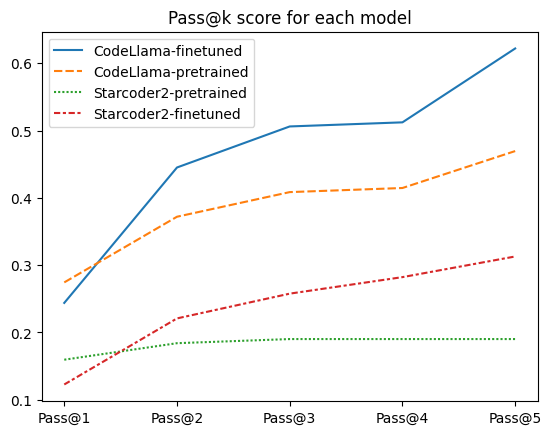

In [ ]:
sns.lineplot(all_pass_scores.T)
plt.title("Pass@k score for each model")